In [127]:
import numpy as np
import pandas as pd

#Visualisation Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.basemap import Basemap
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

#Training and Preprocessing Libraries
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import datetime as dt
from sklearn.linear_model import LogisticRegression    
from sklearn.ensemble import RandomForestClassifier    
from sklearn import tree    
from sklearn.feature_selection import SelectFromModel
from numpy import loadtxt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from xgboost import XGBClassifier    
from sklearn.model_selection import train_test_split
import eli5   # python计算permutation importance工具包   
from eli5.sklearn import PermutationImportance
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [108]:
class_names = ['Fatal', 'Severe', 'Slight']

In [109]:
data = pd.read_csv("./2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv")

data['Did_Police_Officer_Attend_Scene_of_Accident'].head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: object

In [110]:
def preprocessing(data):
    #Drop useless columns and nan values
    data.drop(['Junction_Detail', 
               'Junction_Control', 
               'Accident_Index',
               'Date',
               'Special_Conditions_at_Site', 
               'Carriageway_Hazards', 
               'Did_Police_Officer_Attend_Scene_of_Accident', 
               'LSOA_of_Accident_Location', 
               'Local_Authority_(District)', 
               'Local_Authority_(Highway)','Number_of_Casualties'], axis=1, inplace=True)
    data.dropna(inplace=True)
    
    #Drop rows with 'Unknown' values
    data = data[data.Weather_Conditions!='Unknown']
    data = data[data.Road_Type!='Unknown']
    
    #Encode "String" Labels into "Int" Labels for easy training
    le = LabelEncoder()
    data["Pedestrian_Crossing-Physical_Facilities"]= le.fit_transform(data["Pedestrian_Crossing-Physical_Facilities"])
    data["Light_Conditions"]= le.fit_transform(data["Light_Conditions"])
    data["Weather_Conditions"] = le.fit_transform(data["Weather_Conditions"])
    data["Road_Surface_Conditions"] = le.fit_transform(data["Road_Surface_Conditions"])
    data["Pedestrian_Crossing-Human_Control"] = le.fit_transform(data["Pedestrian_Crossing-Human_Control"])
    data["Road_Type"] = le.fit_transform(data["Road_Type"])
    
    #Converting Time into Int for easy training
    data["Time"]= data["Time"].astype(str)
    data['Time']=data['Time'].str.slice(0,2, 1)
    data["Time"]= data["Time"].astype(int)
    
    #Creating 3 additional columns, one each for each class we need to classify into
    onehot = pd.get_dummies(data.Accident_Severity,prefix=['Severity'])
    data["Fatal"] = onehot["['Severity']_1"]
    data["Severe"] = onehot["['Severity']_2"]
    data["Slight"] = onehot["['Severity']_3"]
    
    return (data)
print(data.columns)

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year'],
      dtype='object')


In [111]:
data = preprocessing(data)

In [112]:
#data.describe()
data.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Day_of_Week,Time,1st_Road_Class,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Year,Fatal,Severe,Slight
0,527200,178760,-0.169101,51.493429,1,3,2,5,20,3,...,2,3,2,1,0,1,2012,0,0,1
1,524930,181430,-0.200838,51.517931,1,3,2,4,17,4,...,2,2,2,1,0,1,2012,0,0,1
2,525860,178080,-0.188636,51.487618,1,3,2,3,10,3,...,2,5,4,1,0,1,2012,0,0,1
3,524980,181030,-0.200259,51.514325,1,3,1,4,12,5,...,2,2,4,1,0,1,2012,0,0,1
4,526170,179200,-0.183773,51.497614,1,3,1,3,20,4,...,2,2,2,1,0,1,2012,0,0,1


In [113]:
X = [X for X in data if X not in ['Accident_Severity','Severe','Slight','Fatal']] #?

In [114]:
X_train, X_test, y_train, y_test = train_test_split(data[X], data['Fatal'], test_size=0.2, random_state = 400)

In [159]:
# logistic Regression model and accuracy
def logistic_regression(X_train, y_train, X_test, y_test):
    lr = LogisticRegression()
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = lr.predict(np.array(X_test))
    sk_report = metrics.classification_report(
        digits=6,
        y_true=y_test, 
        y_pred=y_pred)
    print("Accuracy", round(metrics.accuracy_score(y_pred, y_test)*100,2))
    print(sk_report)
    print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    #Plot Precision-recall curve
    disp = plot_precision_recall_curve(lr, X_test, y_test)
    disp.ax_.set_title("Precision recall curve for Logistic Regression")

In [138]:
# random_forest model and accuracy
def random_forest_classifier(X_train, y_train, X_test, y_test):
    random_forest = RandomForestClassifier(n_estimators=20)
    random_forest.fit(np.array(X_train),np.array(y_train))
    Y_pred = random_forest.predict(np.array(X_test))
    sk_report = metrics.classification_report(
        digits=4,
        y_true=y_test, 
        y_pred=Y_pred)
    print(sk_report)
    pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    #Plot Precision-recall curve
    disp = plot_precision_recall_curve(random_forest, X_test, y_test)
    disp.ax_.set_title("Precision recall curve for Random Forest")
    #Plot feature importances
    plt.figure(figsize=(15,8))
    plt.title("Top features for predicting fatality")
    plt.xlabel("Confidence")
    feat_importances = pd.Series(random_forest.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(40).plot(kind='barh')

In [149]:
# XGBoost model
def xgboost(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(
                            learning_rate =0.05,
                             n_estimators=100,
                             max_depth=3,
                             min_child_weight=1,
                             gamma=0.3,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'multi:softprob',
                             nthread=4,
                             scale_pos_weight=1,
                             num_class=2,
                             seed=27
                        ).fit(np.array(X_resampled_train), np.array(y_resampled_train))
    Y_pred = xgb.predict(np.array(X_test))
    sk_report = metrics.classification_report(
        digits=4,
        y_true=y_test, 
        y_pred=Y_pred)
    print(sk_report)
    print(pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    #Plot Precision-recall curve
    disp = plot_precision_recall_curve(xgb, np.array(X_test), np.array(y_test))
    disp.ax_.set_title("Precision recall curve for XGBOOST")

In [162]:
def SVM(X_train, y_train, X_test, y_test):
    from sklearn import svm
    clf = svm.SVC()
    clf.fit(np.array(X_train), np.array(y_train))
    Y_pred = svm.predict(np.array(X_test))
    sk_report = metrics.classification_report(digits=4,y_true=y_test, y_pred=Y_pred)
    print(sk_report)
    print(pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    #Plot Precision-recall curve
    disp = plot_precision_recall_curve(clf, np.array(X_test), np.array(y_test))
    disp.ax_.set_title("Precision recall curve for SVM")

In [121]:
#SMOTE
from imblearn.over_sampling import SMOTE
oversampler=SMOTE(random_state=0)
X_resampled_train, y_resampled_train = oversampler.fit_sample(X_train, y_train)

In [122]:
#Count before SMOTE
y_train.value_counts()

0    359595
1      4252
Name: Fatal, dtype: int64

In [123]:
#Count after SMOTE
pd.Series(y_resampled_train).value_counts()

1    359595
0    359595
dtype: int64

              precision    recall  f1-score   support

           0     0.9904    0.9997    0.9950     89977
           1     0.8261    0.1157    0.2030       985

    accuracy                         0.9902     90962
   macro avg     0.9082    0.5577    0.5990     90962
weighted avg     0.9886    0.9902    0.9865     90962



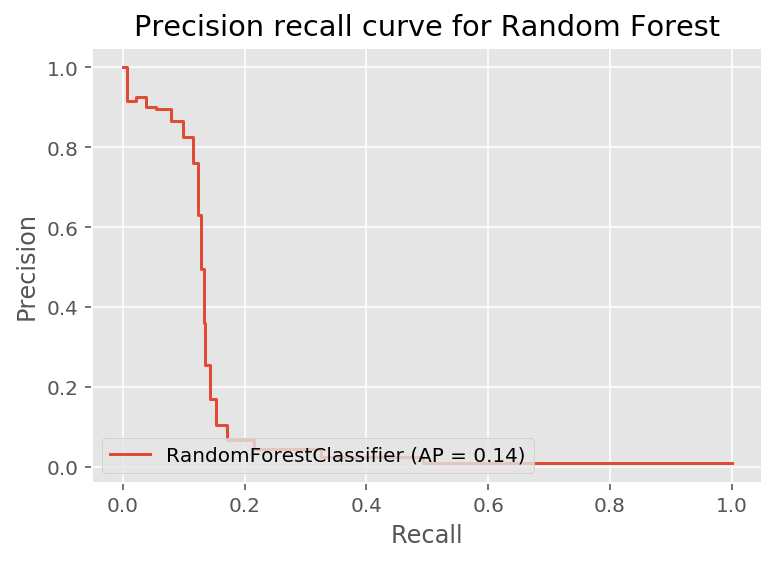

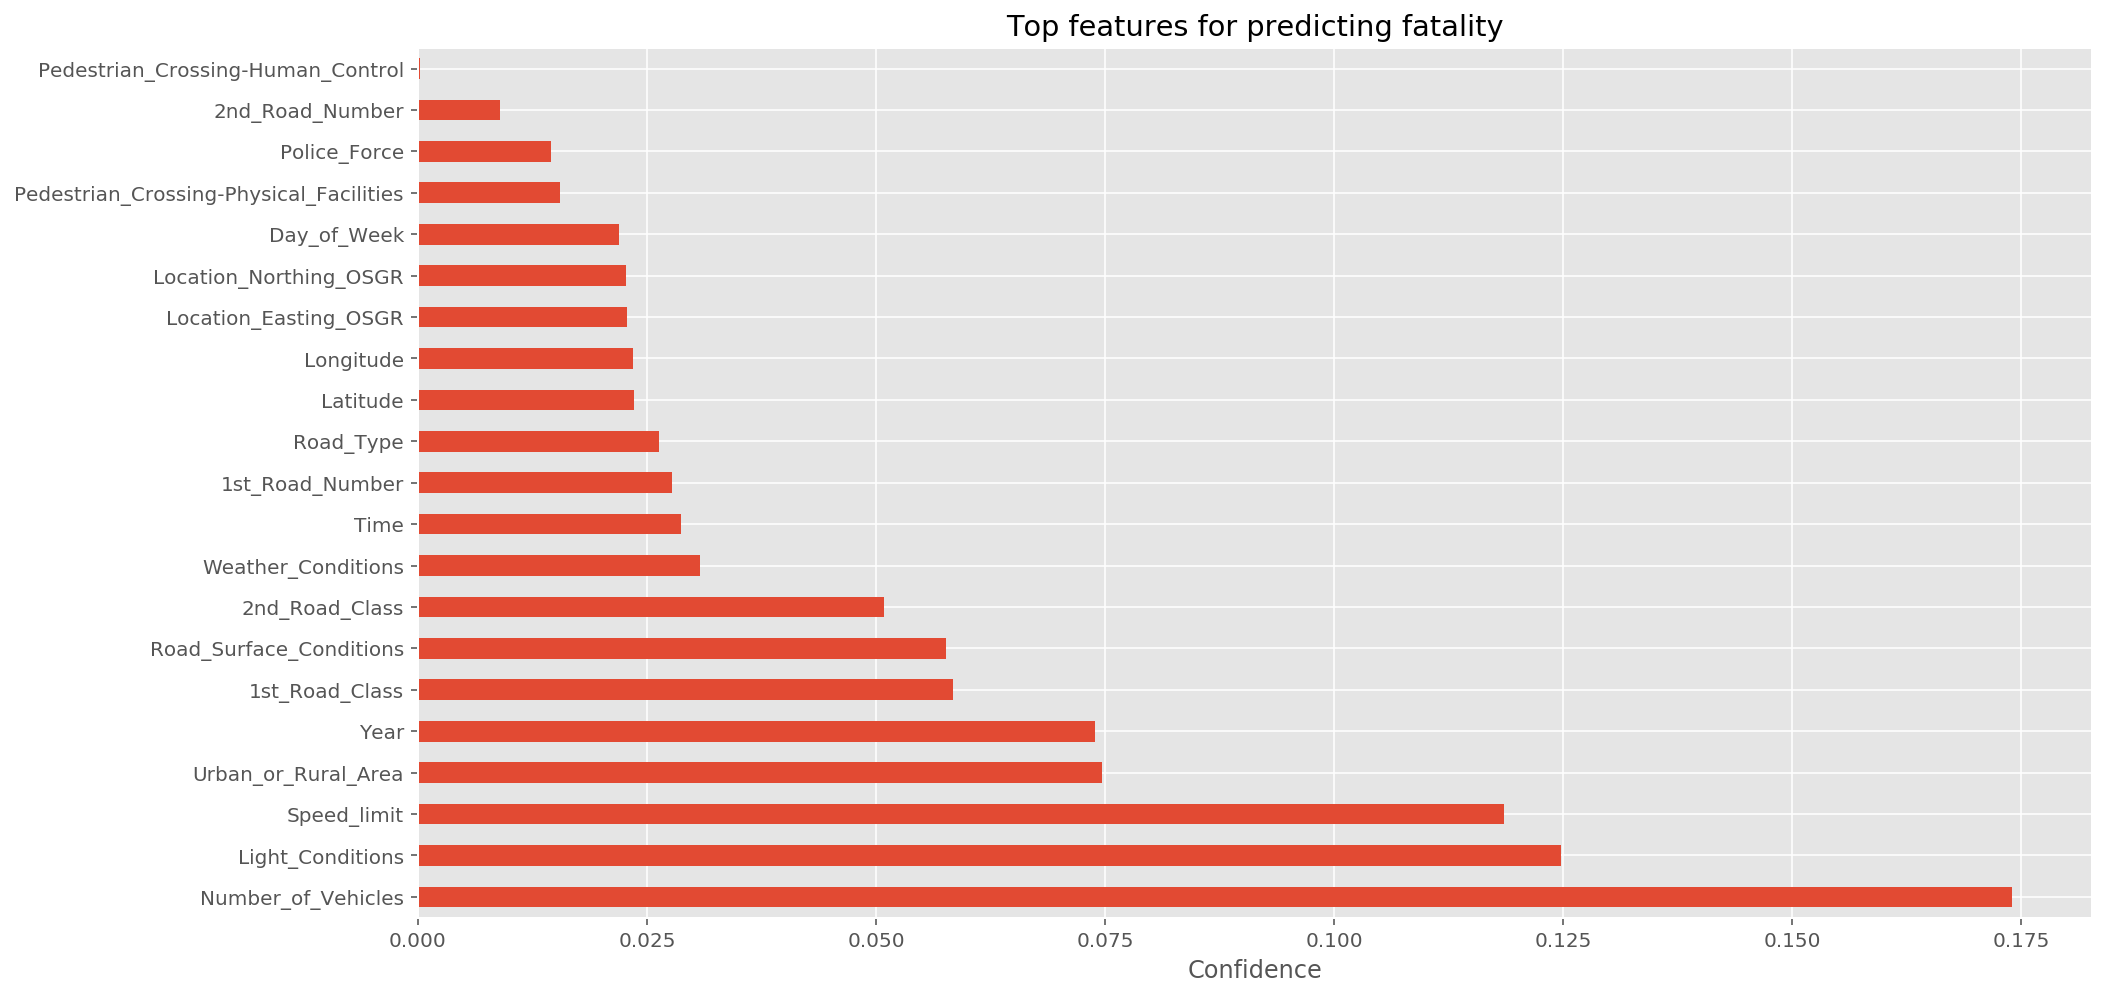

In [141]:
# random forest after SMOTES
random_forest_classifier(pd.DataFrame(X_resampled_train, columns=X_train.columns), y_resampled_train, X_test, y_test)

              precision    recall  f1-score   support

           0     0.9914    0.8971    0.9419     89977
           1     0.0302    0.2924    0.0547       985

    accuracy                         0.8905     90962
   macro avg     0.5108    0.5947    0.4983     90962
weighted avg     0.9810    0.8905    0.9323     90962



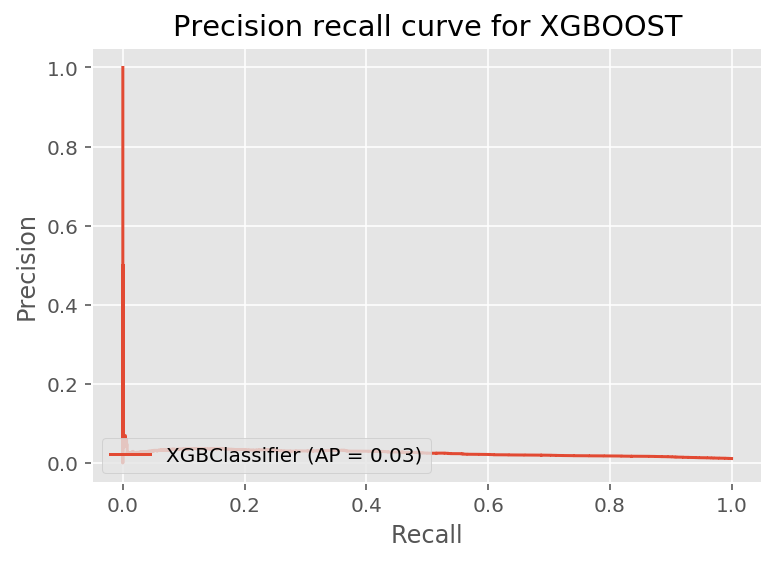

In [161]:
#xgboost after SMOTES
xgboost(X_resampled_train, y_resampled_train, X_test, y_test)


Accuracy 54.66
              precision    recall  f1-score   support

           0   0.990974  0.546640  0.704606     89977
           1   0.012993  0.545178  0.025382       985

    accuracy                       0.546624     90962
   macro avg   0.501984  0.545909  0.364994     90962
weighted avg   0.980383  0.546624  0.697251     90962

Predicted      0      1    All
Actual                        
0          49185  40792  89977
1            448    537    985
All        49633  41329  90962


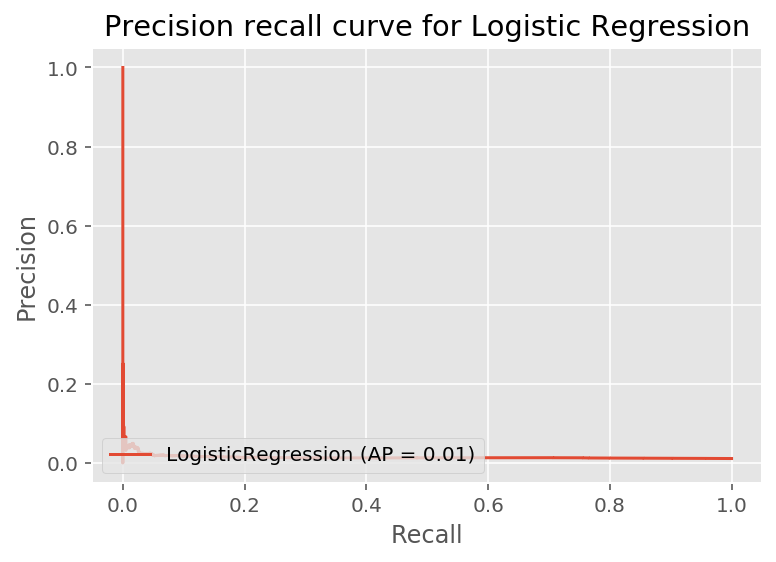

In [160]:
#Logistic regression after SMOTES
logistic_regression(X_resampled_train, y_resampled_train, X_test, y_test)

In [ ]:
#Classification using SVM
SVM(X_resampled_train, y_resampled_train, X_test, y_test)

In [ ]:
# k-fold cross validation evaluation of xgboost model
# CV model
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(lr, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# k-fold cross validation evaluation of xgboost model
# CV model
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(random_forest, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# k-fold cross validation evaluation of xgboost model
# CV model
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(xgb, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))